Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# DL03 K-Means Clustering

### Lab Description

This laboratory exercise introduces K-Means, an **unsupervised learning algorithm** used for clustering data into distinct groups based on feature similarity. The algorithm iteratively refines cluster centers and assignments to organize unlabeled data into meaningful patterns.

In this lab, you will apply the K-Means algorithm to a set of 2D data points, visualize how clusters are formed and updated over iterations, and examine the effect of varying the number of clusters.

### How K-Means Works

1. **Initialization**: Randomly select `k` initial cluster centers.
2. **Assignment Step**: Assign each data point to the nearest cluster based on Euclidean distance to the cluster centers.
3. **Update Step**: Recalculate each cluster’s center as the mean of all points assigned to it.
4. **Repeat**: Repeat the assignment and update steps until the cluster assignments do not change or a maximum number of iterations is reached.

### What you can expect to learn

- Understanding the K-Means Algorithm: Learn the iterative process of initialization, assignment, and update that leads to convergence.
- Clustering and Visualization: Apply K-Means to 2D data and visualize the clustering outcome at each step.
- Convergence Behavior: Observe how cluster assignments and centers evolve over time until convergence.
- Impact of Cluster Count: Explore how different values of `k` affect the quality and granularity of clustering results.


### Import necessary libraries

In [1]:
%matplotlib inline
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Plot Decision Regions

We visualize how a classifier separates classes in a 2D dataset by plotting decision regions. It helps assess model performance and generalization, especially for non-linear cases like the moon dataset.


In [2]:
from matplotlib.colors import ListedColormap


def _PlotDecisionRegions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ("s", "x", "o", "^", "v")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[: len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=[cmap(idx)],
            linewidths=1,
            marker=markers[idx],
            label=cl,
            edgecolors="k",
        )

    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(
            X_test[:, 0],
            X_test[:, 1],
            facecolor="none",
            alpha=1.0,
            linewidths=1,
            marker="o",
            edgecolors="black",
            s=55,
            label="test set",
        )

### Prepare Dataset

In this lab, we randomly generate three groups of data with distinct distributions and visualize them.

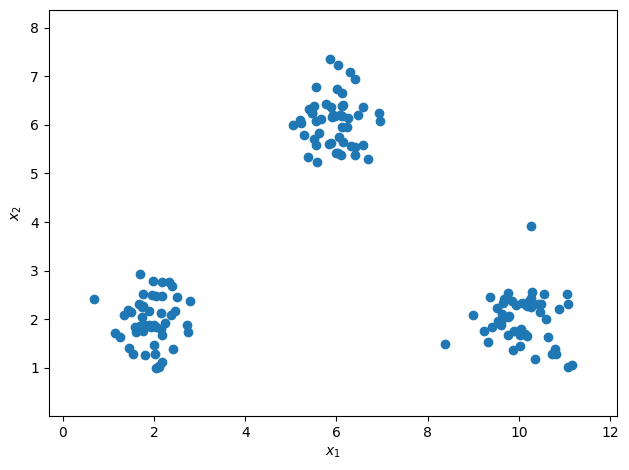

In [3]:
url = "https://raw.githubusercontent.com/SDeepDreamS/Remote-Lab-Datasets/refs/heads/main/generated_kmeans_data.csv"
df = pd.read_csv(url)

x = df.to_numpy()

plt.scatter(x[:, 0], x[:, 1])

plt.xlim(x[:, 0].min() - 1, x[:, 0].max() + 1)
plt.ylim(x[:, 1].min() - 1, x[:, 1].max() + 1)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()
plt.show()

## K-means Algorithms

We implement a K-Means clustering algorithm from scratch. It allows for configurable settings such as number of clusters, initialization method (`random` or `k-means++`), number of restarts, and maximum iterations. The goal is to group data points into clusters based on distance and update cluster centers iteratively until convergence.

In [4]:
class KMeans:
    def __init__(self, n_clusters=8, init="random", n_init=10, max_iter=300):
        self.n_clusters = n_clusters
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.cluster_center = None

    def _init_cluster_center(self, X):
        if self.init == "random":
            idx = np.random.choice(range(X.shape[0]), self.n_clusters, replace=False)
            cc = X[idx]
        elif self.init == "k-means++":
            idx = np.random.choice(range(X.shape[0]), 1, replace=False)
            cc = X[idx]
            for _ in range(self.n_clusters - 1):
                dist = []
                total = 0

                for i in X:
                    min_dist = np.min([np.linalg.norm(i - cc[j]) for j in range(cc.shape[0])])

                    dist.append(min_dist * min_dist)
                    total += min_dist * min_dist

                total *= random.random()
                for j, dis in enumerate(dist):
                    total -= dis
                    if total > 0:
                        continue
                    cc = np.vstack([cc, X[j]])
                    break
        return cc

    def predict(self, X):
        y = np.zeros(X.shape[0])

        for i, xx in enumerate(X):
            label = np.argmin([np.linalg.norm(xx - self.cluster_center[z]) for z in range(self.n_clusters)])
            y[i] = label

        return y

    def score(self, cluster_center, X):
        avg_dist = 0
        for xx in X:
            min_dist = np.min([np.linalg.norm(xx - cluster_center[i]) for i in range(self.n_clusters)])
            total_dist = np.sum([np.linalg.norm(xx - cluster_center[i]) for i in range(self.n_clusters)])
            avg_dist -= 2 * min_dist - total_dist
        avg_dist /= X.shape[0]
        return avg_dist

    def _update_center(self, cluster_center, X):
        center = np.zeros((self.n_clusters, X.shape[1]))
        y = np.zeros(X.shape[0])
        for i, xx in enumerate(X):
            label = np.argmin([np.linalg.norm(xx - cluster_center[z]) for z in range(self.n_clusters)])
            y[i] = label

        for i, _ in enumerate(cluster_center):
            now_c = np.mean(X[y == i], axis=0)
            center[i] = now_c
        return center

    def fit(self, X):
        for i in range(self.n_init):
            Max = -1
            center = self._init_cluster_center(X)

            for j in range(self.max_iter):
                pre_center = center
                center = self._update_center(center, X)  # update
                diff = center - pre_center
                if not diff.any():
                    break
            score = self.score(center, X)

            if score > Max:
                self.cluster_center = center

### Visualization

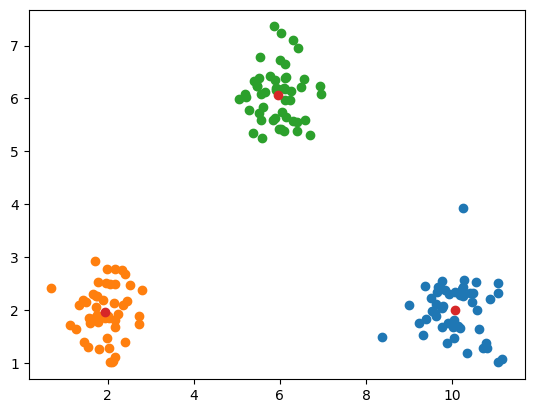

In [5]:
kmeans = KMeans(3, init="k-means++")
kmeans.fit(x)
y = kmeans.predict(x)

plt.scatter(x[y == 0, 0], x[y == 0, 1])
plt.scatter(x[y == 1, 0], x[y == 1, 1])
plt.scatter(x[y == 2, 0], x[y == 2, 1])
plt.scatter(kmeans.cluster_center[:, 0], kmeans.cluster_center[:, 1])
plt.show()

/tmp/ipykernel_17258/3229598591.py:23: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


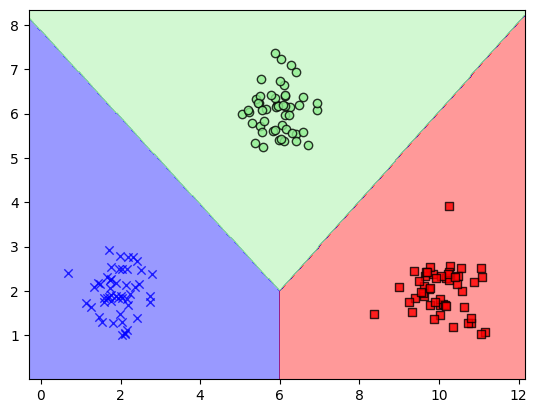

In [6]:
_PlotDecisionRegions(x, y, kmeans)